# **Face Shape Classification Model Using Semi-Supervised Networks** <br>


**1Team Member** : Yungbum Park(Team Leader), Yejin Kim, Seunghyun Kwan, Hojun Kim, Sangjun Choi <br>
**1Team Github** : https://github.com/1team1768/1team.git<br><br>
**Dataset** : LFW-5590, SCUT-FBP5500_v2.1(Faceshape labels were made by 1Team)<br><br>
**Reference** <br> David_Lee's_Science.log<br>  https://www.tensorflow.org/tutorials/load_data/images?hl=ko
<br> Pseudo-Label : The Simple and Efficient Semi-Supervised Learning Method for Deep Neural Networks(2013)
<br> Unsupervised feature learning for self-tuning neural networks Jongbin Ryu, Ming-Hsuan Yang, Jongwoo Lim(2021)
<br> Self-training with Noisy Student improves ImageNet classification(2019)

## **1. Import DataSet**

In [ ]:
from pathlib import Path # 이미지 데이터 이상 확인
import imghdr

data_dir = "/content/drive/MyDrive/Faceshape_project/train/testing_set/"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import pathlib

In [ ]:
data_dir = "/content/drive/MyDrive/Faceshape_project/facetype"
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1535


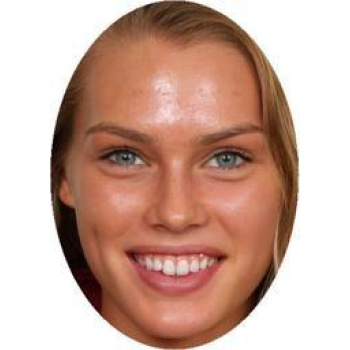

In [ ]:
long = list(data_dir.glob('long/*'))
PIL.Image.open(str(long[0]))

## **2. Data Preprocessing**

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1535 files belonging to 5 classes.
Using 1228 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1535 files belonging to 5 classes.
Using 307 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['angulate', 'circle', 'egg', 'long', 'triangle']


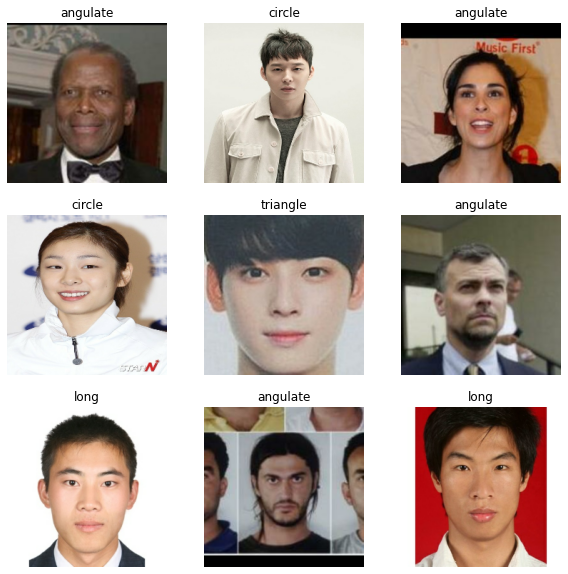

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **3. Create Teacher Model Using Transfer Learning**
<p>base model: EfficientNet-B7

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, pooling = 'avg' , input_shape = (224,224 ,3),
                                                               weights = 'imagenet')
base_model.trainable = False
# base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (224,224 ,3), weights = 'imagenet')
# base_model.trainable = True
# input_y = tf.keras.utils.to_categorical(train_ds, 5)
# test_y = tf.keras.utils.to_categorical(val_ds, 5)

# 모델 layer 설계
inputs = tf.keras.Input(shape=(224,224,3))
# x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(inputs, training=False)
x = Flatten()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(5, activation = 'softmax')(x)
model_res = tf.keras.Model(inputs, outputs)


258088960/258076736 [==============================] - 7s 0us/step


In [ ]:
model_res.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 5)                 12805     
                                                                 
Total params: 64,110,492
Trainable params: 12,805
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
model_res.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['sparse_categorical_accuracy'])

early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model_res.fit(train_ds,validation_data=val_ds, epochs=8, callbacks=[early])

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


39/39 [==============================] - 167s 4s/step - loss: 1.1865 - sparse_categorical_accuracy: 0.5521 - val_loss: 0.9263 - val_sparse_categorical_accuracy: 0.6938
Epoch 2/8
39/39 [==============================] - 16s 414ms/step - loss: 0.7957 - sparse_categorical_accuracy: 0.7353 - val_loss: 0.7859 - val_sparse_categorical_accuracy: 0.7427
Epoch 3/8
39/39 [==============================] - 16s 417ms/step - loss: 0.6805 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.7190 - val_sparse_categorical_accuracy: 0.7622
Epoch 4/8
39/39 [==============================] - 16s 419ms/step - loss: 0.6171 - sparse_categorical_accuracy: 0.7801 - val_loss: 0.6787 - val_sparse_categorical_accuracy: 0.7655
Epoch 5/8
39/39 [==============================] - 16s 422ms/step - loss: 0.5736 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.6513 - val_sparse_categorical_accuracy: 0.7752
Epoch 6/8
39/39 [==============================] - 16s 423ms/step - loss: 0.5406 - sparse_categorical_accuracy: 

### 3.1 evaluate transfer model

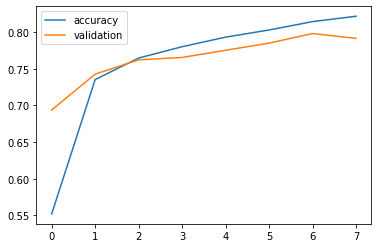

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
loss, acc = model_res.evaluate(val_ds)

10/10 [==============================] - 3s 333ms/step - loss: 0.6039 - sparse_categorical_accuracy: 0.7915


In [ ]:
 model_res.save('/content/drive/MyDrive/Faceshape_project/ef_transfer7915.h5')

## **4. Semi-Supervised learning(noisy student method)**

### 5.0 preprocessing self-tuning dataset

In [ ]:
s_dir = "/content/drive/MyDrive/Faceshape_project/train/lfw_5590"

In [ ]:
s_dir = pathlib.Path(s_dir)

In [ ]:
image_count = len(list(s_dir.glob('*.jpg')))
print(image_count)

5590


In [ ]:
pseudo_feature = tf.keras.preprocessing.image_dataset_from_directory(
  s_dir,
  labels=None,
  seed=12,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5590 files belonging to 1 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

pseudo_data = pseudo_feature.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
len(pseudo_data)

175

### 5.1 self-tuning cycle1

In [ ]:
# student_model1 = tf.keras.models.load_model('/content/drive/MyDrive/Faceshape_project/studentmodel_ef1.h5')
train_ds = tf.data.experimental.load('/content/drive/MyDrive/Faceshape_project/train_ds')
val_ds = tf.data.experimental.load('/content/drive/MyDrive/Faceshape_project/val_ds')
pseudo_data = tf.data.experimental.load('/content/drive/MyDrive/Faceshape_project/pseudo_data')

In [ ]:
model_res = tf.keras.models.load_model('/content/drive/MyDrive/Faceshape_project/ef_transfer7655.h5')

In [ ]:
s_cycle = model_res.predict(pseudo_data)

In [ ]:
def pseudo_pro(feature,s_cycle):

    accuracy_list = []


    for i in range(len(s_cycle)):
        id = np.argmax(s_cycle[i])
        accuracy_list.append(id)
    

    pseudo_label = tf.convert_to_tensor(accuracy_list)

    pse_feature = feature.unbatch()
    pse_feature = list(pse_feature)

    pseudo_dataset = tf.data.Dataset.from_tensor_slices(
    (pse_feature, pseudo_label)).shuffle(10000).batch(32)

    combined_dataset = train_ds.concatenate(pseudo_dataset).shuffle(10000)

    # test_dataset = combined_dataset.take(0.2*len(combined_dataset)) 
    # train_dataset = combined_dataset.skip(0.2*len(combined_dataset))

    AUTOTUNE = tf.data.AUTOTUNE
    combined_datasett =combined_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # test_dataset =test_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    # train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
    
    return combined_dataset



In [ ]:
def augment(image):
  
  
   # Random crop back to the original size
  
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.random_flip_left_right(image)
  return image

In [ ]:
combined_dataset = pseudo_pro(pseudo_data, s_cycle)
combined_dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
pseudo_dataset = combined_dataset.map(lambda x, y: (augment(x),y))

In [ ]:
test_ps = pseudo_dataset.take(50) 
train_ps = pseudo_dataset.skip(50)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, pooling = 'avg' , input_shape = (224,224 ,3), weights = 'imagenet')
base_model.trainable = False
# base_model = ResNet50(include_top=False, pooling = 'avg' , input_shape = (224,224 ,3), weights = 'imagenet')
# base_model.trainable = True
# input_y = tf.keras.utils.to_categorical(train_ds, 5)
# test_y = tf.keras.utils.to_categorical(val_ds, 5)

# 모델 layer 설계
inputs = tf.keras.Input(shape=(224,224,3))
# x = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(x)
# x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(inputs, training=False)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(5, activation = 'softmax')(x)
self_model = tf.keras.Model(inputs, outputs)

In [ ]:
self_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 12805     
                                                                 
Total params: 64,110,492
Trainable params: 12,805
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
self_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['sparse_categorical_accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
student_history = self_model.fit(train_ps,validation_data= test_ps,epochs=8, callbacks=[early])

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


164/164 [==============================] - 102s 516ms/step - loss: 0.4041 - sparse_categorical_accuracy: 0.8762 - val_loss: 0.2298 - val_sparse_categorical_accuracy: 0.9209
Epoch 2/8
164/164 [==============================] - 83s 497ms/step - loss: 0.2207 - sparse_categorical_accuracy: 0.9212 - val_loss: 0.1242 - val_sparse_categorical_accuracy: 0.9625
Epoch 3/8
164/164 [==============================] - 84s 501ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.9469 - val_loss: 0.1391 - val_sparse_categorical_accuracy: 0.9513
Epoch 4/8
164/164 [==============================] - 84s 501ms/step - loss: 0.1409 - sparse_categorical_accuracy: 0.9475 - val_loss: 0.1887 - val_sparse_categorical_accuracy: 0.9352
Epoch 5/8
164/164 [==============================] - 84s 502ms/step - loss: 0.1422 - sparse_categorical_accuracy: 0.9486 - val_loss: 0.1183 - val_sparse_categorical_accuracy: 0.9547
Epoch 6/8
164/164 [==============================] - 84s 502ms/step - loss: 0.1458 - sparse_categor

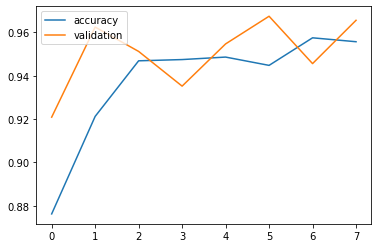

In [ ]:
import matplotlib.pyplot as plt

plt.plot(student_history.history['sparse_categorical_accuracy'])
plt.plot(student_history.history['val_sparse_categorical_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
loss, acc = self_model.evaluate(val_ds,verbose=2)

10/10 - 3s - loss: 0.6071 - sparse_categorical_accuracy: 0.7166 - 3s/epoch - 323ms/step


In [ ]:
tf.keras.models.save_model(self_model,'/content/drive/MyDrive/Faceshape_project/studentmodel1.h5')
# tf.data.experimental.save(train_ds,'/content/drive/MyDrive/Faceshape_project/train_ds')
# tf.data.experimental.save(val_ds,'/content/drive/MyDrive/Faceshape_project/val_ds')
# tf.data.experimental.save(pseudo_data,'/content/drive/MyDrive/Faceshape_project/pseudo_data')

### 5.2 self-tuning cycle2

In [ ]:
s_cycle = self_model.predict(pseudo_data)

In [ ]:
pseudo_dataset = pseudo_pro(pseudo_data, s_cycle)
pseudo_dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
pseudo_dataset = pseudo_dataset.map(lambda x, y: (augment(x),y))

In [ ]:
test_ps = pseudo_dataset.take(50) 
train_ps = pseudo_dataset.skip(50)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, pooling = 'avg' , input_shape = (224,224 ,3), weights = 'imagenet')
base_model.trainable = False

# 모델 layer 설계
inputs = tf.keras.Input(shape=(224,224,3))
# x = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(x)
# x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(inputs, training=False)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(5, activation = 'softmax')(x)
student_model1 = tf.keras.Model(inputs, outputs)

In [ ]:
student_model1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 flatten_3 (Flatten)         (None, 2560)              0         
                                                                 
 dropout_2 (Dropout)         (None, 2560)              0         
                                                                 
 dense_3 (Dense)             (None, 5)                 12805     
                                                                 
Total params: 64,110,492
Trainable params: 12,805
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
student_model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['sparse_categorical_accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
student_history2 = student_model1.fit(train_ps, validation_data=test_ps, epochs=8, callbacks=[early])

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


164/164 [==============================] - 102s 516ms/step - loss: 0.3739 - sparse_categorical_accuracy: 0.8824 - val_loss: 0.2238 - val_sparse_categorical_accuracy: 0.9297
Epoch 2/8
164/164 [==============================] - 83s 497ms/step - loss: 0.2169 - sparse_categorical_accuracy: 0.9235 - val_loss: 0.1798 - val_sparse_categorical_accuracy: 0.9400
Epoch 3/8
164/164 [==============================] - 84s 500ms/step - loss: 0.1555 - sparse_categorical_accuracy: 0.9452 - val_loss: 0.1105 - val_sparse_categorical_accuracy: 0.9613
Epoch 4/8
164/164 [==============================] - 84s 502ms/step - loss: 0.1622 - sparse_categorical_accuracy: 0.9410 - val_loss: 0.1469 - val_sparse_categorical_accuracy: 0.9531
Epoch 5/8
164/164 [==============================] - 84s 505ms/step - loss: 0.1399 - sparse_categorical_accuracy: 0.9487 - val_loss: 0.1247 - val_sparse_categorical_accuracy: 0.9550
Epoch 6/8
164/164 [==============================] - 84s 503ms/step - loss: 0.1193 - sparse_categor

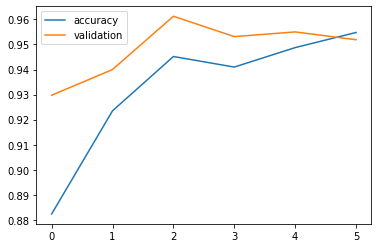

In [ ]:
import matplotlib.pyplot as plt

plt.plot(student_history2.history['sparse_categorical_accuracy'])
plt.plot(student_history2.history['val_sparse_categorical_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
loss, acc = student_model1.evaluate(val_ds,verbose=1)

10/10 [==============================] - 3s 322ms/step - loss: 0.6523 - sparse_categorical_accuracy: 0.7199


In [ ]:
tf.keras.models.save_model(student_model1,'/content/drive/MyDrive/Faceshape_project/mar15/student_model1.h5')
tf.data.experimental.save(train_ds,'/content/drive/MyDrive/Faceshape_project/mar15/train_ds')
tf.data.experimental.save(val_ds,'/content/drive/MyDrive/Faceshape_project/mar15/val_ds')
tf.data.experimental.save(pseudo_data,'/content/drive/MyDrive/Faceshape_project/mar15/pseudo_data')

### 5.3 self-tuning cycle3

In [ ]:
student_model1 = tf.keras.models.load_model('/content/drive/MyDrive/Faceshape_project/mar15/student_model1.h5')
train_ds = tf.data.experimental.load('/content/drive/MyDrive/Faceshape_project/mar15/train_ds')
val_ds = tf.data.experimental.load('/content/drive/MyDrive/Faceshape_project/mar15/val_ds')
pseudo_data = tf.data.experimental.load('/content/drive/MyDrive/Faceshape_project/mar15/pseudo_data')

In [ ]:
s_cycle = student_model1.predict(pseudo_data)

In [ ]:
pseudo_dataset = pseudo_pro(pseudo_data, s_cycle)
pseudo_dataset

<ShuffleDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
pseudo_dataset = pseudo_dataset.map(lambda x, y: (augment(x),y))

In [ ]:
test_ps = pseudo_dataset.take(50) 
train_ps = pseudo_dataset.skip(50)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import datasets
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, pooling = 'avg' , input_shape = (224,224 ,3), weights = 'imagenet')
base_model.trainable = False

# 모델 layer 설계
inputs = tf.keras.Input(shape=(224,224,3))
# x = tf.keras.layers.experimental.preprocessing.Resizing(224, 224)(x)
# x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(inputs, training=False)
x = Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = Dense(5, activation = 'softmax')(x)
student_model2 = tf.keras.Model(inputs, outputs)

In [ ]:
student_model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 2560)             64097687  
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dropout (Dropout)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 5)                 12805     
                                                                 
Total params: 64,110,492
Trainable params: 12,805
Non-trainable params: 64,097,687
_________________________________________________________________


In [ ]:
student_model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['sparse_categorical_accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
student_history3 = student_model2.fit(train_ps, validation_data=test_ps, epochs=8, callbacks=[early])

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


164/164 [==============================] - 86s 384ms/step - loss: 0.3827 - sparse_categorical_accuracy: 0.8757 - val_loss: 0.1987 - val_sparse_categorical_accuracy: 0.9453
Epoch 2/8
164/164 [==============================] - 61s 354ms/step - loss: 0.2120 - sparse_categorical_accuracy: 0.9281 - val_loss: 0.1345 - val_sparse_categorical_accuracy: 0.9600
Epoch 3/8
164/164 [==============================] - 61s 353ms/step - loss: 0.1429 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.1700 - val_sparse_categorical_accuracy: 0.9287
Epoch 4/8
164/164 [==============================] - 61s 353ms/step - loss: 0.1340 - sparse_categorical_accuracy: 0.9512 - val_loss: 0.1351 - val_sparse_categorical_accuracy: 0.9481
Epoch 5/8
164/164 [==============================] - 61s 353ms/step - loss: 0.1289 - sparse_categorical_accuracy: 0.9547 - val_loss: 0.1481 - val_sparse_categorical_accuracy: 0.9478


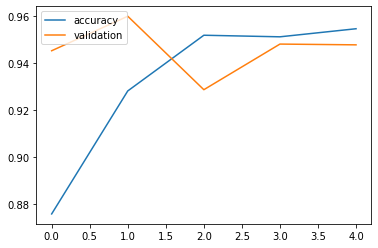

In [ ]:
import matplotlib.pyplot as plt

plt.plot(student_history3.history['sparse_categorical_accuracy'])
plt.plot(student_history3.history['val_sparse_categorical_accuracy'])
plt.legend(['accuracy', 'validation'], loc = 'upper left')
plt.show()

In [ ]:
tf.keras.models.save_model(student_model2,'/content/drive/MyDrive/Faceshape_project/mar15/studentmodel2.h5')

In [ ]:
loss, acc = student_model2.evaluate(val_ds,verbose=1)

39/39 [==============================] - 9s 226ms/step - loss: 0.5375 - sparse_categorical_accuracy: 0.8062


In [ ]:
img = tf.keras.preprocessing.image.load_img(
    '/content/drive/MyDrive/Faceshape_project/train/testing_set/angulate/square (1).jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = student_model2.predict(img_array)


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions[0])], 100 * np.max(predictions[0]))
)

This image most likely belongs to triangle with a 95.02 percent confidence.


## **6. Result**

우리팀은 Self-training with Noisy Student improves ImageNet classification(2019)에 소개 된 Pseudo-labeling을 통하여 얼굴형 분류 모델을 설계하고, 정확도를 상승시키기 위해 다음과 같은 프로세스를 진행하였다.<br>
<br>
Reset-50 모델을 베이스모델로 Transfer-learning을 진행하였다.<br>
그 결과 정확도 **0.79** 모델을 확보했다.
<br>
<br>이어서 Self-training with Noisy Student improves ImageNet classification(2019)에 소개된 Noisy Student 알고리즘을 통해 Self-training 진행하였다.
<br>
<br>그 결과 정화도가 **Transfer learning: 0.79 -> Noisy Student: 0.80**으로 상승하였다.


## **Future Plans**

우리팀은 데이터셋을 추가하여 총 3000개의 FaceShape dataset구축을 목표로하고있다.
<br> 또한Efficientnet뿐만 아니라 Alexnet,VGG-19,Resnet등 다양한 모델을 활용하여 Semi-Supervised Learning을 진행할것이다.<br>
추가로 해당 모델들의 정확도를 비교하고 가장 정확도가 높은 모델을 사용하여 얼굴형별 안경추천 웹사이트를 구축할것이다.<br>
마지막으로 해당 프로젝트에서 사용된 Noisy Student 딥러닝 모델과 기존의 SVM모델을 비교하여 딥러닝 모델의 사용이 유의미한것인지 검토할것이다.